In [1]:
%matplotlib inline
# disable autoreload for global dataset
%load_ext autoreload
%autoreload 2

In [2]:
import seaborn as sns

In [3]:
from learn import *
from gen_val_postproc_building import *

In [4]:
num_gpus = 2
gpu_start = 4
num_workers = 3 * num_gpus
device_ids = range(gpu_start, gpu_start + num_gpus)
torch.cuda.set_device(gpu_start)

bs = 15

## Plot predictions

In [5]:
model_name = 'deeplab'

In [6]:
data = None
print(datapaths)

['data/train/AOI_3_Paris_Train', 'data/train/AOI_2_Vegas_Train', 'data/train/AOI_4_Shanghai_Train', 'data/train/AOI_5_Khartoum_Train']


In [7]:
#resume
learn, denorm, data = learner_on_dataset(datapaths[1], bs, device_ids, num_workers, model_name=model_name,
                                         debug=False, global_dataset=True, data=data, num_slice=9, sz=256,)
(trn_x,trn_y), (val_x,val_y) = data


Data finished loading: data/train/AOI_2_Vegas_Train


## plots

In [8]:
learn.load('deeplab-vegas')

In [9]:
%%time
preds = learn.predict()

RuntimeError: cuda runtime error (2) : out of memory at /opt/conda/conda-bld/pytorch_1518244421288/work/torch/lib/THC/generic/THCStorage.cu:58

In [13]:
%%time
with ThreadPoolExecutor(max_workers=8) as e:
    x, y = list(zip(*list(e.map(learn.data.val_dl.get_batch, [[o] for o in range(preds.shape[0])]))))

NameError: name 'preds' is not defined

In [14]:
len(x)

NameError: name 'x' is not defined

In [ ]:
x, y, preds = [np.squeeze(o) for o in (x, y, preds)]

In [ ]:
thresh = np.linspace(0, 1, 20)

In [ ]:
score = [jaccard_coef(T(preds), T(bool_pred(y, t).astype('float'))) for t in thresh]

In [ ]:
plt.plot(thresh, score)

In [ ]:
idx = 394
data = zip([denorm(x[idx]).squeeze()], [y[idx].squeeze()], [preds[idx].squeeze()], [bool_pred(preds[idx], 0).squeeze()])
plot_ims(data)

In [ ]:
scores = None

In [ ]:
scores, idx = plot_worse_preds(x, y, preds, learn, jaccard_coef, shift=50,
                          scores=scores, is_best=0, thresh=0.5)

In [ ]:
np.mean(scores)

In [ ]:
idx

## CRF

In [ ]:
import numpy as np
try:
    import cPickle as pickle
except ImportError:
    import pickle

from pystruct import learners
import pystruct.models as crfs
from pystruct.utils import SaveLogger


C = 0.01

n_states = 21
print("number of samples: %s" % len(x))
class_weights = 1. / np.bincount(np.hstack(data_train['Y']))
class_weights *= 21. / np.sum(class_weights)
print(class_weights)

model = crfs.EdgeFeatureGraphCRF(inference_method='qpbo',
                                 class_weight=class_weights,
                                 symmetric_edge_features=[0, 1],
                                 antisymmetric_edge_features=[2])

experiment_name = "edge_features_one_slack_trainval_%f" % C

ssvm = learners.NSlackSSVM(
    model, verbose=2, C=C, max_iter=100000, n_jobs=-1,
    tol=0.0001, show_loss_every=5,
    logger=SaveLogger(experiment_name + ".pickle", save_every=100),
    inactive_threshold=1e-3, inactive_window=10, batch_size=100)
ssvm.fit(data_train['X'], data_train['Y'])

data_val = pickle.load(open("data_val_dict.pickle"))
y_pred = ssvm.predict(data_val['X'])

# we throw away void superpixels and flatten everything
y_pred, y_true = np.hstack(y_pred), np.hstack(data_val['Y'])
y_pred = y_pred[y_true != 255]
y_true = y_true[y_true != 255]

print("Score on validation set: %f" % np.mean(y_true == y_pred))

### Guided Filter

In [ ]:
sns.set(style="white")
x.shape

In [ ]:
srcs = ((preds > 0.5) * 255).astype('uint8')
guides = (denorm(x).squeeze() * 255).astype('uint8')
gts = (y * 255).astype('uint8')

In [ ]:
guides.shape, srcs.shape

0.6863501207953913 0.6868874541316364


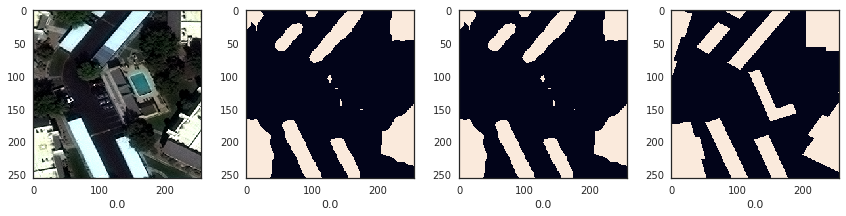

In [20]:
idx = 435
guide = (denorm(x[idx]).squeeze() * 255).astype('uint8')
gt = (y[idx] * 255).astype('uint8')
src = (np.copy(preds[idx] > 0.5) * 255).astype('uint8')
dst = np.empty(src.shape)
radius = 1
eps = 60

filtered = cv2.ximgproc.guidedFilter(guide, src, radius, eps, dst, -1)
col1 = [guide]
col2 = [src]
col3 = [filtered > 255 // 2]
data = zip(col1, col2, col3, [y[idx]])

plot_ims(data, figsize=3)
print(jaccard_coef(filtered > 255 // 2, gt), jaccard_coef(src, gt))

In [ ]:
%%time
rows, cols = 5, 10
radius = np.arange(1, 6, 1).astype('uint8')
eps = np.arange(1, 80, 80 / cols).astype('uint8')
res = np.empty([rows, cols] + list(srcs.shape))
for row, r in enumerate(radius):
    for col, e in enumerate(eps):    
#         for i, src in enumerate(srcs):
        with ThreadPoolExecutor(max_workers=8) as e:
            res_batch = list(e.map((partial(cv2.ximgproc.guidedFilter, radius=r, eps=e), guides, srcs))
            for i, res_im in enumerate(res_batch):
                res[row,col, i] = res_im

In [ ]:
%%time
score_mat = np.empty([rows, cols])
for row, r in enumerate(radius):
    with ThreadPoolExecutor(max_workers=8) as e:
        res_cols = list(e.map(jaccard_coef, res[row] > 255//2, np.broadcast_to(gts, [cols] + list(gts.shape))))
        for i, res_col in enumerate(res_cols):
            score_mat[row, i] = res_col

In [ ]:
gts.shape, srcs.shape

In [28]:
%%time
jaccard_coef(V(gts.astype('float')), V(srcs.astype('float')))

CPU times: user 15.4 s, sys: 3.07 s, total: 18.5 s
Wall time: 1.78 s


0.822637851589949

In [ ]:
%%time
jaccard_coef_cuda(V(gts.astype('float')), V(srcs.astype('float')))

In [ ]:
sns.set(style="white")
cmap = sns.diverging_palette(220, 10, as_cmap=True)
ax = sns.heatmap(score_mat, cmap=cmap,
            square=True, linewidths=.5, cbar_kws={"shrink": 1})
# ax.xaxis.set_ticks(eps)
print(score_mat.argmax())

In [31]:
score_mat.reshape(-1)[score_mat.argmax()]

0.8227282975620246

In [ ]:
eps.astype('float')

### Contour

In [ ]:
class args:
    def __init__(self, val_dir):
        self.val_dir = val_dir
        self.save_dir = 'data/working/images/v5/save_paris/'
        self.stride = 24
        self.batch = 7
        self.proc_method = None
        self.resize = 1
        self.map_size = 256

In [ ]:
pred_images(learn, args('data/working/images/v5/test_full_rgb/paris'))